In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
chars = sorted(list(set(''.join(words))))
ctoi = {c:i+1 for i,c in enumerate(chars)}
ctoi['.']=0
itoc = {i:c for c,i in ctoi.items()}

In [4]:
class LinearLayer:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5 # conserves s.d. of 1. not really needed when using batch norm
    self.bias = torch.zeros(fan_out) if bias else None # bias does nothing if batch normalisation used
  
  def __call__(self, x):
    self.out = x @ self.weight
    if not(self.bias == None):
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

In [5]:
class BatchNormLayer:
  
  def __init__(self, dim, eps=1e-5, momentum=0.01):
    self.eps = eps # prevent div by zero
    self.momentum = momentum
    self.training = True

    self.gamma = torch.ones(dim) # batch norm weights. Want these to be equal at init
    self.beta = torch.zeros(dim) # batch norm biases can be zero at init

    self.running_mean = torch.zeros(dim) # for use after training to standardise across entire training set
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # forward
    if self.training:
      x_mean = x.mean(0, keepdim=True)
      x_var = x.var(0, keepdim=True)
    else:
      x_mean = self.running_mean
      x_var = self.running_var
    xhat = (x - x_mean) / torch.sqrt(x_var + self.eps)
    self.out = self.gamma * xhat + self.beta
    
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * x_mean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * x_var
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

In [6]:
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  
  def parameters(self):
    return []

In [7]:
block_size = 5
def build_dataset(words):
    X, Y = [], []

    for word in words:
        context = [0] * block_size
        for char in word + '.':
            X.append(context[:])
            Y.append(ctoi[char])
            context = context[1:] + [ctoi[char]]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42442)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [8]:
emb_dim = 10
n_hidden = 200
vocab_size = 27
g = torch.Generator().manual_seed(42442)

C = torch.randn((vocab_size, emb_dim), generator=g)
layers = [
  LinearLayer(emb_dim * block_size, n_hidden, bias=False), BatchNormLayer(n_hidden), Tanh(),
  LinearLayer(n_hidden, n_hidden, bias=False), BatchNormLayer(n_hidden), Tanh(),
  LinearLayer(n_hidden, n_hidden, bias=False), BatchNormLayer(n_hidden), Tanh(),
  LinearLayer(n_hidden, n_hidden, bias=False), BatchNormLayer(n_hidden), Tanh(),
  LinearLayer(n_hidden, vocab_size, bias=False), BatchNormLayer(vocab_size)
]

parameters = [C] + [param for layer in layers for param in layer.parameters()]
for param in parameters:
  param.requires_grad = True

In [9]:
steps = []
losses = []
ud = []
batch_size = 32
max_steps = 200000
momentum = 0.01

for i in range(1, max_steps+1):
    
    #random batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    
    # training loop forward
    # get embeddings
    emb = C[Xtr[ix]]

    # linear layer
    # apply weights biases and then activation function
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Ytr[ix])

    for layer in layers:
        layer.out.retain_grad()
    
    #backward
    for param in parameters:
        param.grad=None
    loss.backward()

    # update params
    lr = 0.01 if i < 100000 else 0.005
    for param in parameters:
        param.data -= param.grad * lr
    
    steps.append(i)
    losses.append(loss.log10().item())

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    losses.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*param.grad).std() / param.data.std()).log10().item() for param in parameters])

  10000/ 200000: 2.2241
  20000/ 200000: 1.7584
  30000/ 200000: 1.9550
  40000/ 200000: 2.2019
  50000/ 200000: 2.1162
  60000/ 200000: 1.8804
  70000/ 200000: 2.1523
  80000/ 200000: 1.9449
  90000/ 200000: 2.4518
 100000/ 200000: 1.9185
 110000/ 200000: 2.1418
 120000/ 200000: 1.9103
 130000/ 200000: 2.1518
 140000/ 200000: 1.7303
 150000/ 200000: 1.9068
 160000/ 200000: 2.9887
 170000/ 200000: 1.9105
 180000/ 200000: 2.1037
 190000/ 200000: 1.8448
 200000/ 200000: 1.7391


layer 2 (      Tanh): mean +0.00, std 0.63, saturated: 5.44%
layer 5 (      Tanh): mean -0.00, std 0.66, saturated: 5.92%
layer 8 (      Tanh): mean +0.00, std 0.67, saturated: 5.55%
layer 11 (      Tanh): mean +0.00, std 0.68, saturated: 5.34%


Text(0.5, 1.0, 'activation distribution')

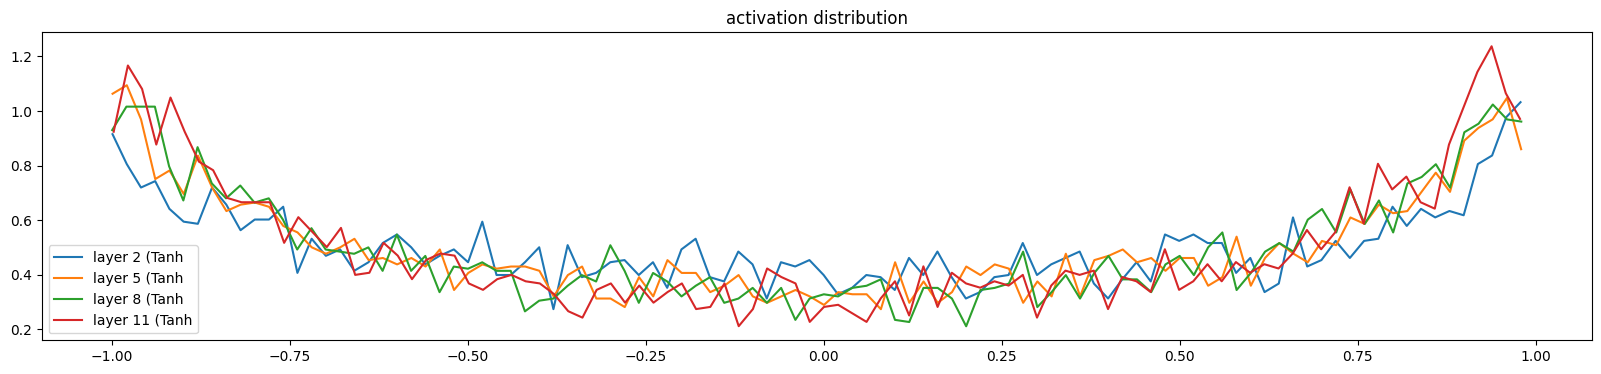

In [10]:
# visualize
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]): # output layer not included
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends)
plt.title('activation distribution')

# gradients go to 0 if these tend to 1. Want low saturation

layer 2 (      Tanh): mean +0.000000, std 4.478287e-03
layer 5 (      Tanh): mean +0.000000, std 4.498166e-03
layer 8 (      Tanh): mean -0.000000, std 4.727251e-03
layer 11 (      Tanh): mean +0.000000, std 4.358068e-03


Text(0.5, 1.0, 'gradient distribution')

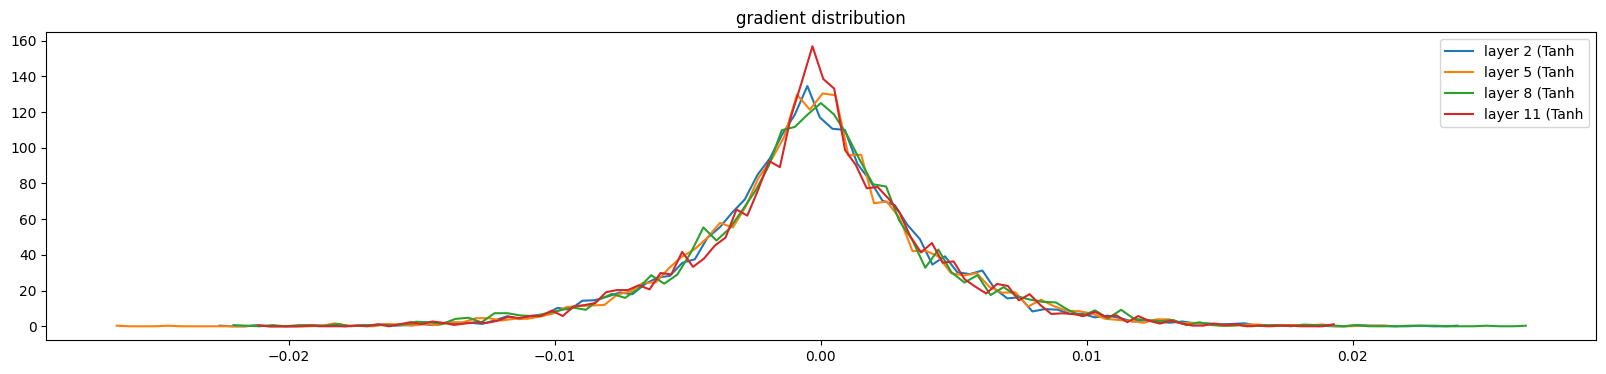

In [11]:
# gradient distribution
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]): # output layer excluded
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 1.819597e-02 | grad:data ratio 1.698415e-02
weight  (50, 200) | mean -0.000205 | std 1.780899e-02 | grad:data ratio 1.174098e-01
weight (200, 200) | mean +0.000037 | std 1.360379e-02 | grad:data ratio 1.674047e-01
weight (200, 200) | mean -0.000046 | std 1.420618e-02 | grad:data ratio 1.748233e-01
weight (200, 200) | mean +0.000011 | std 1.291229e-02 | grad:data ratio 1.607321e-01
weight  (200, 27) | mean -0.000023 | std 2.509301e-02 | grad:data ratio 2.265832e-01


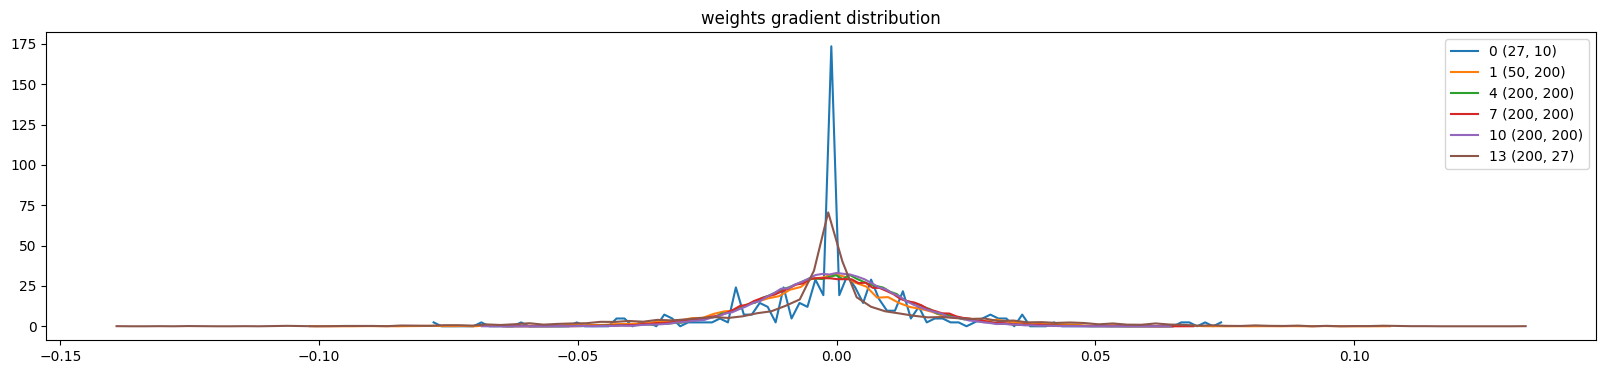

In [12]:
# weights gradient distribution
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

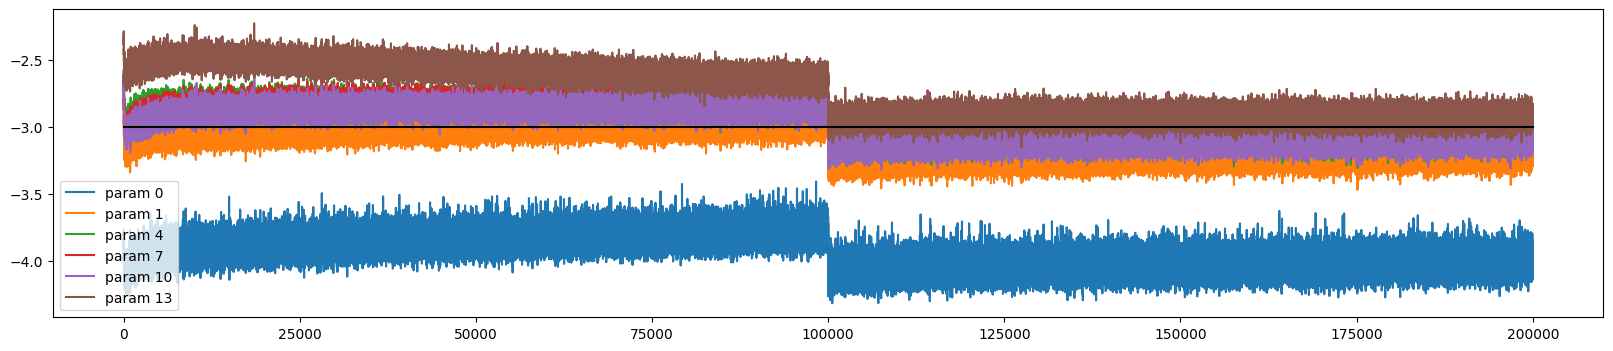

In [13]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # aim for ~1e-3
plt.legend(legends)

In [14]:
@torch.no_grad()
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xval, Yval),
    'test': (Xte, Yte),
  }[split]
  emb = C[x]
  x = emb.view(emb.shape[0], -1) #(N, block_size * emb_dim)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 1.8473267555236816
val 2.027176856994629


In [15]:
# generate samples
for _ in range(10):
    
    output = []
    # init is all ...
    context = [0] * block_size
    while True:
      # forward the nn
      emb = C[torch.tensor([context])]
      x = emb.view(emb.shape[0], -1)
      for layer in layers:
        x = layer(x)
      logits = x
      dist = F.softmax(logits, dim=1)

      ix = torch.multinomial(dist, num_samples=1, generator=g).item()

      context = context[1:] + [ix]
      output.append(ix)
      if ix == 0:
        break
    
    print(''.join(itoc[i] for i in output))

nrace.
zachariya.
haniya.
gutcy.
blaiklee.
kayleia.
nellam.
dnashca.
leiln.
devah.
